前面的例子是分类问题，其目标是预测输入数据点所对应的单一离散的标签。  
另一种常见的机器学习问题是回归问题，它预测一个连续值而不是离散的标签。  
例如，根据气象数据预测明天的气温，根据软件说明书预测完成软件项目所需要的时间。  
logistic回归其实是分类算法

### 3.6.1 The Boston Housing Price dataset 波士顿房价数据集
利用已知当时郊区的一些数据点(比如犯罪率、当地房产税率等)预测20世纪70年代中期波士顿郊区房屋价格的中位数。  

它包含的数据点相对较少，只有506个，分为404个训练样本和102个测试样本。  
输入数据的每个特征（比如犯罪率）都有不同的取值范围。例如，有些特性是比例，取值范围为0-1; 有的取值范围为1-12; 还有的取值范围为0-100，等等。

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.datasets import boston_housing
from tensorflow.keras import losses
from tensorflow.keras import metrics
import matplotlib.pyplot as plt

In [2]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57344/57026 [==============================] - 0s 0us/step


In [3]:
train_data.shape # 404个训练样本，每个样本有13个数值特征，比如人均犯罪率、每个住宅的平均房间数、高速公路可达性等。

(404, 13)

In [4]:
test_data.shape

(102, 13)

In [5]:
train_targets # 目标是房屋价格的中位数，单位是千美元

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

### 3.6.2 Preparing the data 准备数据
将取值范围差异很大的数据输入到神经网络中，这是有问题的。网络可能会自动适应这种取值范围不同的数据，但学习肯定变得更加困难。  

对于这种数据，普遍采用的最佳实践是对每个特征做标准化，  
即对于输入数据的每个特征（输入数据矩阵中的列），减去特征平均值，再除以标准差，  
这样得到的特征平均值为 0，标准差为 1。用 Numpy可以很容易实现标准化。

In [6]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

注意，用于测试数据标准化的均值和标准差都是在训练数据上计算得到的。在工作流程中，你不能使用在测试数据上计算得到的任何结果，即使是像数据标准化这么简单的事情也不行。

### 3.6.3 Building your model 构建网络
由于样本数量不多，我们只使用一个非常小的网络，其中包含两个隐藏层，防止过拟合。

In [7]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

#网络的最后一层只有一个单元，没有激活，是一个线性层。这是标量回归（标量回归是预测单一连续值的回归）的典型设置。添加激活函数将会限制输出范围。
#例如，如果向最后一层添加sigmoid激活函数，网络只能学会预测0~1范围内的值。这里最后一层是纯线性的，所以网络可以学会预测任意范围内的值。
#编译网络用的是mse损失函数，即均方误差（MSE，mean   squared error），预测值与目标值之差的平方。这是回归问题常用的损失函数。
#平均绝对误差（MAE，mean absolute error）。它是预测值与目标值之差的绝对值。
#比如，如果这个问题的MAE等于0.5，就表示你预测的房价与实际价格平均相差500美元

### 3.6.4 Validating your approach using K-fold validation 用K折验证
为了在调节网络参数（比如训练的轮数）的同时对网络进行评估，你可以将数据划分为训练集和验证集，但由于数据点很少，验证集会非常小（比如大约100个样本）。因此，验证分数可能会有很大波动，验证集的划分方式可能会造成验证分数上有很大的方差，这样就无法对模型进行可靠的评估。

在这种情况下，最佳做法是使用 K折交叉验证（见图  3-11）。这种方法将可用数据划分为 K个分区（K通常取4或5），实例化K个相同的模型，将每个模型在K-1个分区上训练，并在剩下的一个分区上进行评估。模型的验证分数等于K个验证分数的平均值。

In [13]:
k = 4
num_val_samples = len(train_data) // k # // 取整数
num_epochs = 100
all_scores = []
for i in range(k):
    print(f"Processing fold #{i}") # 准备验证数据
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate( # 准备训练数据
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    
    model = build_model() # 构建模型
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=16, verbose=0) # verbose 静默模式
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [12]:
all_scores

[2.0724925994873047, 2.497851610183716, 2.5270614624023438, 2.4348413944244385]

In [14]:
all_scores

[2.0876450538635254, 2.4016518592834473, 2.545879364013672, 2.3473398685455322]

在这个例子中，预测的房价与实际价格平均相差 3000美元，考虑到实际价格范围在  10 000~50 000美元，这一差别还是很大的。  
我们让训练时间更长一点，达到500个轮次。为了记录模型在每轮的表现，我们需要修改训练循环，以保存每轮的验证分数记录。

In [15]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [17]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

In [27]:
# 计算每个轮次中所有折 MAE的平均值。
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

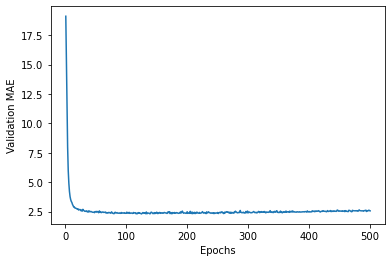

In [20]:
#Plotting validation scores
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

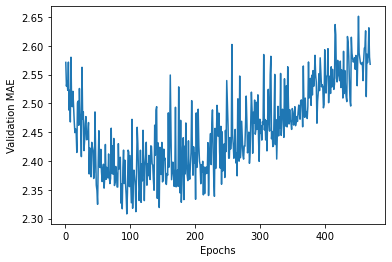

In [32]:
#Plotting validation scores, excluding the first 30 data points
#删除前 30个数据点，因为它们的取值范围与曲线上的其他点不同。
#将每个数据点替换为前面数据点的指数移动平均值，以得到光滑的曲线。

truncated_mae_history = average_mae_history[30:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

MAE在100轮后不再显著降低，之后就开始过拟合。

In [33]:
# Training the final model
model = build_model()
model.fit(train_data, train_targets,
          epochs=100, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 1ms/step - loss: 17.4520 - mae: 2.7569


In [34]:
test_mae_score

2.756945848464966

你预测的房价还是和实际价格相差约 2550美元。

### 3.6.5 Generating predictions on new data

In [35]:
predictions = model.predict(test_data)
predictions[0]

array([8.909162], dtype=float32)

### 3.6.6 小结
回归问题使用的损失函数与分类问题不同。回归常用的损失函数是均方误差（MSE）。  
同样，回归问题使用的评估指标也与分类问题不同。显而易见，精度的概念不适用于回归问题。常见的回归指标是平均绝对误差（MAE）。  
如果输入数据的特征具有不同的取值范围，应该先进行预处理，对每个特征单独进行缩放。  
如果可用的数据很少，使用  K折验证可以可靠地评估模型。  
如果可用的训练数据很少，最好使用隐藏层较少（通常只有一到两个）的小型网络，以避免严重的过拟合。